# Семинар 2. Часть 1.


### Доска:

- Bias-Variance разложение

<img src="img/bv_model_complex.png">
Пример: Bishop, C.M. Pattern Recognition and Machine Learning, стр 150

<h1 align="center">Bagging</h1> 

см. доска

- Нужны модели с маленьким смещением
- Нужны некоррелированные модели

Какие?

### Some Facts about the Trees and Linear models

- Linear Model
    - Слишком простые
    - Не сильно меняются при небольшом изменении выборки
- Tree Model
    - Слишком сложные -- легко закодировать всю выборку деревом
    - Сильно меняются при небольшом изменении выборки
    
### Загрузим датасет Титаник

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score

import pydot  # sudo pip3 install pydot --upgrade
from io import StringIO
from IPython.display import Image 

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
titanic = pd.read_csv('./data/titanik_train.csv')[['Survived', 'Pclass', 'Sex', 'Age', 'Fare']]
print(titanic.head())

sex_encoder = LabelEncoder()
titanic.Sex = sex_encoder.fit_transform(titanic.Sex)
features = ['Pclass', 'Sex', 'Age', 'Fare']
X, y = titanic[features].values, titanic.Survived.values

X = np.nan_to_num(X)

   Survived  Pclass     Sex   Age     Fare
0         0       3    male  22.0   7.2500
1         1       1  female  38.0  71.2833
2         1       3  female  26.0   7.9250
3         1       1  female  35.0  53.1000
4         0       3    male  35.0   8.0500


### Обучим линейную модель на разных подвыборках, похожи ли коэфиценты?

In [3]:
for n_items in [200, 500]:
    reg = LogisticRegression().fit(X[:n_items], y[:n_items])
    print('n_items', n_items, 'w = ',', '.join(map(lambda x: '%.4f' % x, reg.coef_[0])))

n_items 200 w =  -0.4027, -2.3487, -0.0196, -0.0004
n_items 500 w =  -0.6117, -2.4663, -0.0112, 0.0017


### Обучем деревья на тех же подвыборках, похожи ли деревья?

In [4]:
def draw_tree(X, y, n_items):
    tree = DecisionTreeClassifier().fit(X[:n_items], y[:n_items])
    dot_data = StringIO()  
    export_graphviz(tree, out_file=dot_data)  
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
    return Image(graph.create_png())

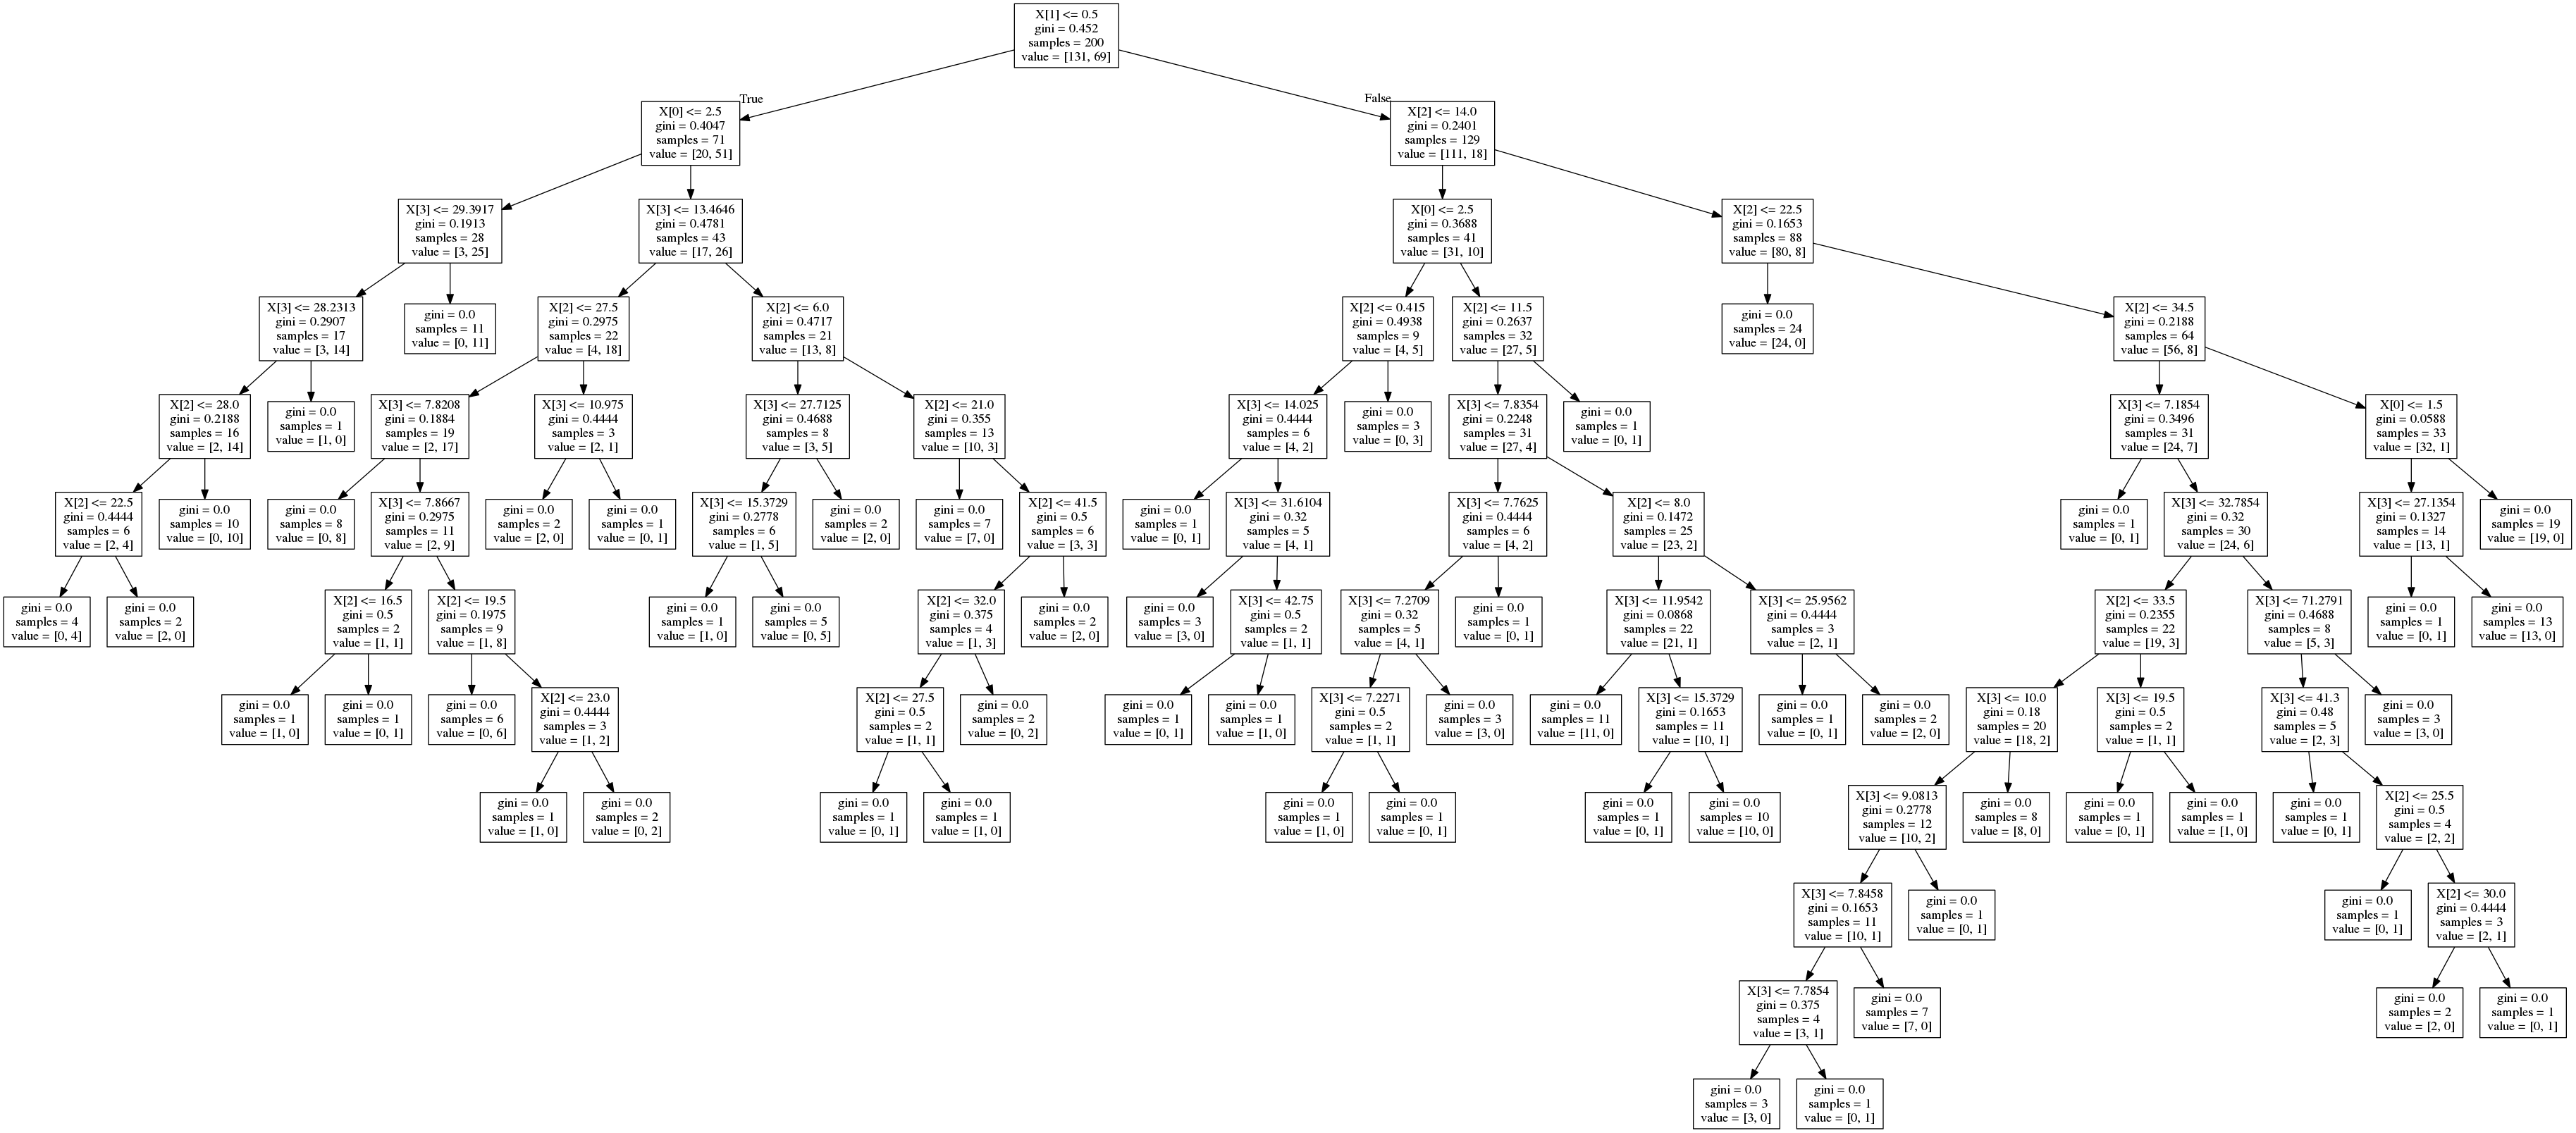

In [5]:
draw_tree(X, y, 200)

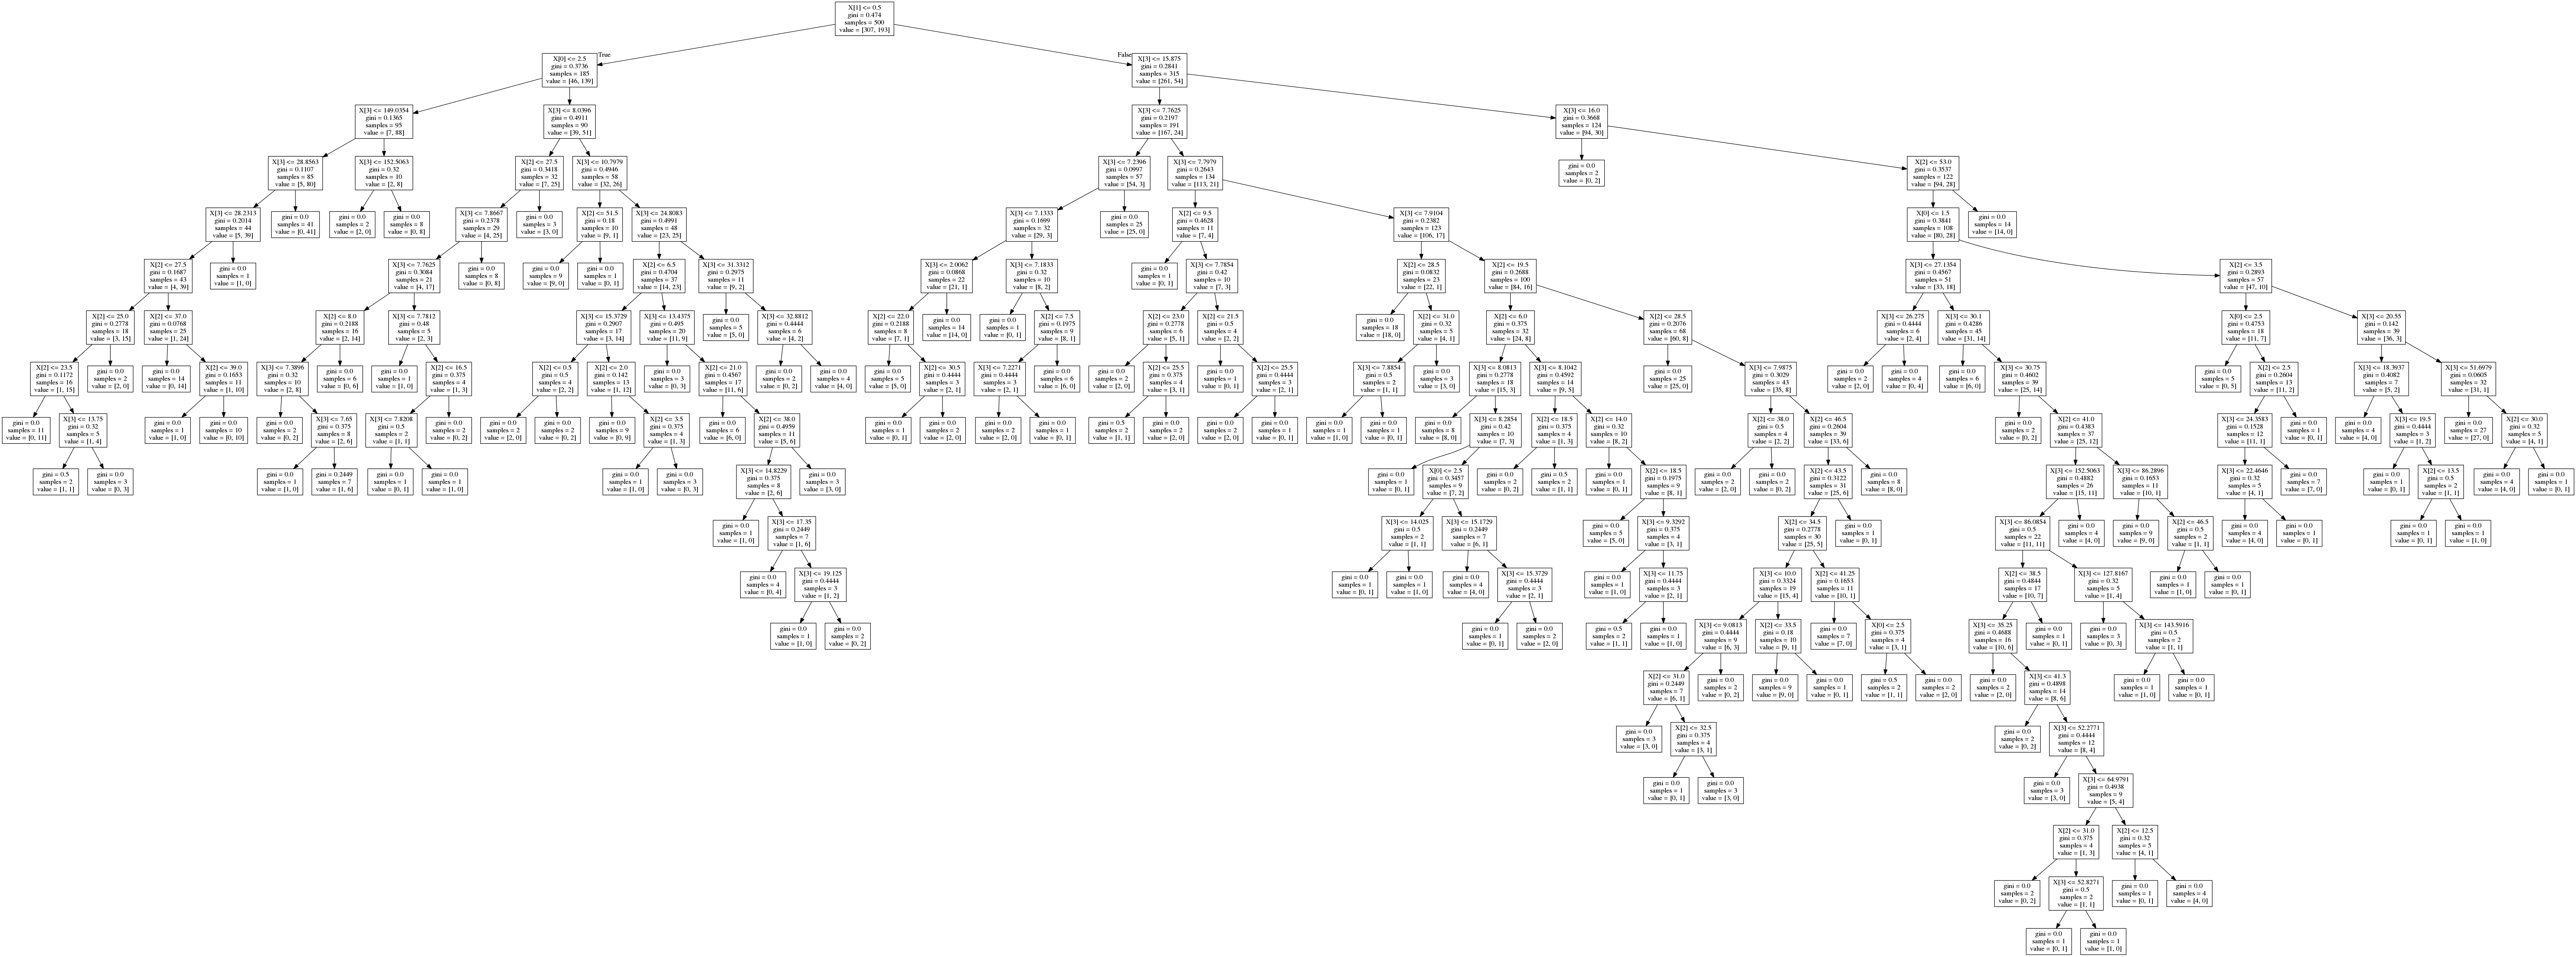

In [6]:
draw_tree(X, y, 500)

### Practical Task Model Correlation (Linear and Tree Bagging)

In [7]:
adult = pd.read_csv(
    './data/adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")

adult.head(2)

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [8]:
adult = pd.get_dummies(adult)
adult.head(2)

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Target_ <=50K,Target_ >50K
0,39,77516,13,2174,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,50,83311,13,0,0,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [9]:
adult["Target"] = adult["Target_ >50K"]
adult.columns[:-3]

Index(['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Workclass_ ?', 'Workclass_ Federal-gov',
       'Workclass_ Local-gov', 'Workclass_ Never-worked',
       ...
       'Country_ Portugal', 'Country_ Puerto-Rico', 'Country_ Scotland',
       'Country_ South', 'Country_ Taiwan', 'Country_ Thailand',
       'Country_ Trinadad&Tobago', 'Country_ United-States',
       'Country_ Vietnam', 'Country_ Yugoslavia'],
      dtype='object', length=108)

In [10]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values

### Model correlation

### Беггинг на лог-регрессиях 

In [11]:
clf1 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100)
scores1 = cross_val_score(clf1, X, y, cv=4, n_jobs=4)
print(scores1)

[ 0.79707653  0.79398034  0.79889435  0.8004914 ]


### Беггинг на девевьях

In [12]:
clf2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)
scores2 = cross_val_score(clf2, X, y, cv=4, n_jobs=4)
print(scores2)

[ 0.84952709  0.85184275  0.85933661  0.85737101]


### Натренируем модели

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)

### Посмотрим на корреляцию предсказаний

In [14]:
pred1 = [clf.predict(X_test) for clf in clf1.estimators_]
pred2 = [clf.predict(X_test) for clf in clf2.estimators_]

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)


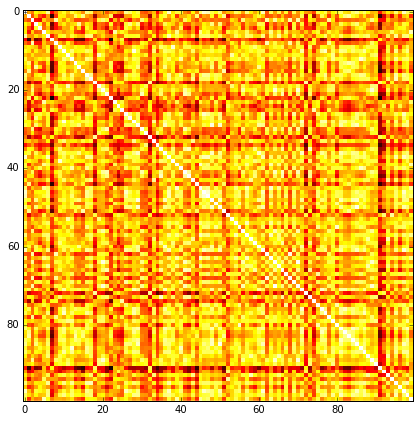

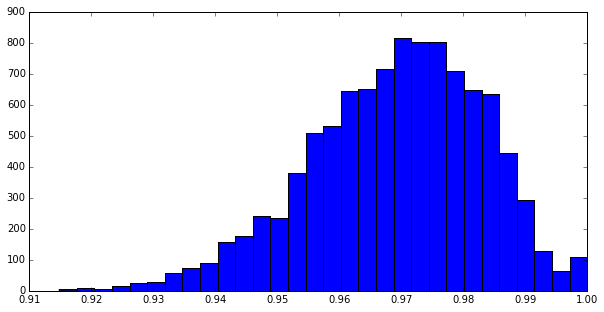

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)


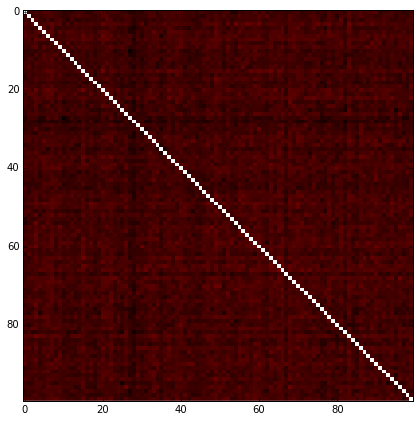

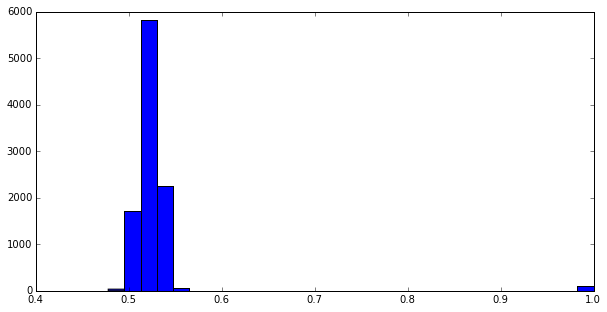

In [15]:
for clf in [clf1, clf2]:
    print(clf)
    
    predictions = [estimator.predict(X_test) for estimator in clf.estimators_]
    estimators_count = len(clf.estimators_)
    corr_matrix = np.zeros((estimators_count, estimators_count))
    for i in range(estimators_count):
        for j in range(estimators_count):
            corr_matrix[i, j] = pearsonr(predictions[i], predictions[j])[0]
    
    plt.figure(figsize=(7, 7))
    plt.imshow(corr_matrix, interpolation='none', cmap='hot')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.hist(corr_matrix.ravel(), bins=30)
    plt.show()

###  Есть ли overfitting с увеличением числа деревьев и сложности?

In [16]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=n_estimators, n_jobs=4)
    clf = clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test)
    print('n_estimators = %4s train_acc = %4s test_acc = %4s' %(n_estimators, train_acc, test_acc))

n_estimators =   10 train_acc = 0.987944075178 test_acc = 0.8485017681
n_estimators =   40 train_acc = 0.998991519597 test_acc = 0.852968546436
n_estimators =  100 train_acc = 0.999954159982 test_acc = 0.854643588312
n_estimators =  200 train_acc =  1.0 test_acc = 0.853992183138
n_estimators =  600 train_acc =  1.0 test_acc = 0.856318630188
n_estimators = 1000 train_acc =  1.0 test_acc = 0.856783919598
CPU times: user 12.5 s, sys: 4.42 s, total: 16.9 s
Wall time: 7min 1s


In [17]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=7), n_estimators=n_estimators, n_jobs=4)
    clf = clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test)
    print('n_estimators = %4s train_acc = %4s test_acc = %4s' %(n_estimators, train_acc, test_acc))

n_estimators =   10 train_acc = 0.861058904424 test_acc = 0.858645077238
n_estimators =   40 train_acc = 0.861838184735 test_acc = 0.858086729946
n_estimators =  100 train_acc = 0.861563144625 test_acc = 0.85827284571
n_estimators =  200 train_acc = 0.861929864772 test_acc = 0.85827284571
n_estimators =  600 train_acc = 0.862067384827 test_acc = 0.857993672064
n_estimators = 1000 train_acc = 0.861104744442 test_acc = 0.857528382654
CPU times: user 7.81 s, sys: 1.73 s, total: 9.54 s
Wall time: 4min 17s


In [18]:
%%time

for n_estimators in [10, 40, 100, 200, 600, 1000]:
    clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=14), n_estimators=n_estimators, n_jobs=4)
    clf = clf.fit(X_train, y_train)
    train_acc, test_acc = accuracy_score(clf.predict(X_train), y_train), accuracy_score(clf.predict(X_test), y_test)
    print('n_estimators = %4s train_acc = %4s test_acc = %4s' %(n_estimators, train_acc, test_acc))

n_estimators =   10 train_acc = 0.910061884025 test_acc = 0.860320119114
n_estimators =   40 train_acc = 0.912995645198 test_acc = 0.863763260748
n_estimators =  100 train_acc = 0.913179005272 test_acc = 0.864135492276
n_estimators =  200 train_acc = 0.914233325693 test_acc = 0.865531360506
n_estimators =  600 train_acc = 0.91294980518 test_acc = 0.865531360506
n_estimators = 1000 train_acc = 0.913545725418 test_acc = 0.866461939326
CPU times: user 8.97 s, sys: 2.72 s, total: 11.7 s
Wall time: 6min 16s


<h1 align="center">Recap</h1> 

**Смещение и разброс**:
    - Ошибки бывают разные
    - Ошибку можно разложить на составляющие части, чтобы лучше понимать, что происходит
    - Это может помочь нам придумать хорошие методы и понимать, как такие методы будут работать

**Bagging**:
    - Одна из лучших техник для построения методов ML
    - Линейно уменьшает Разброс и не уменьшает Смещение 
    - Слабое переобучение
    - НО переобучение ЕСТЬ -- от сложности одного метода, лучше все же немного обрезать деревья

**Что почитать**:
- Hastie, The Elements of Statistical Learning, https://goo.gl/k3wfEU
    - 2.9 Model Selection and the Bias–Variance Tradeoff 
    - 15 Random Forests
- Соколов, Семинары по композиционным методам, https://goo.gl/sn8RyJ
- Andrew Ng, Bias vs. Variance, https://goo.gl/1ISZ6Y 